In [1]:
# TODO:
# Update spaCy to v3 to make proper use of lemmatizer in 'lookup' mode
# Use BalancedRandomForestClassifier to downsample 'normal' class in bootstrap sample (data on which tree is trained)
# Set 'class_weight' parameter of (Balanced)RandomForestClassifier to 'balanced' or 'balanced_subsample'

# import libraries
import pandas as pd
import seaborn as sns
import numpy as np

# natural language processing
import spacy

# plotting
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# built-in libraries
import string
import re

#pd.set_option('display.max_columns', None)  # or 1000
#pd.set_option('display.max_rows', None)     # or 1000
#pd.set_option('display.max_colwidth', -1)   # or 199

# IMPORTING DATASETS

In [2]:
# import dataset holding all available tweets and geo-tags
# more information about the labels of the columns can be found here:
# https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet 
df_tweets_all = pd.read_csv('data/full_tweets_decoded.csv')
df_tweets_all

,Unnamed: 0,tweet_id,coordinates,place_full_name,place_country_code,place_bb_coord,created_at,text
0,0,848337741813358592,NaN,NaN,NaN,NaN,2017-04-02 00:54:13,fucks sake go away stupid anon \xe2\x80\x94 ^ ...
1,1,850344984742174720,NaN,NaN,NaN,NaN,2017-04-07 13:50:17,Carlos Correa had gyalchester as his walkup mu...
2,2,848668638869671939,NaN,NaN,NaN,NaN,2017-04-02 22:49:05,Damn dean just put Corbin to sleep. That Match...
3,3,848338236770582529,NaN,NaN,NaN,NaN,2017-04-02 00:56:11,Dick Tracy Meets Gruesome - the 2017 re-boot\n...
4,4,847542736651767809,NaN,NaN,NaN,NaN,2017-03-30 20:15:09,what idiot called them antacids and not afterb...
...,...,...,...,...,...,...,...,...
54275,54275,849353459669372929,NaN,NaN,NaN,NaN,2017-04-04 20:10:19,RT @elijahdaniel: our comments section is a fu...
54276,54276,849004845877145604,NaN,NaN,NaN,NaN,2017-04-03 21:05:03,OH MY GOD LIZ JUST FUCKING BLOCKED ME IM SCREA...
54277,54277,850750334829854720,NaN,NaN,NaN,NaN,2017-04-08 16:41:00,RT @SilkyRay: Nigga had me fucked up https://t...
54278,54278,849515175254405120,NaN,NaN,NaN,NaN,2017-04-05 06:52:55,Swear to god it's the worst shit ever https://...


The dataset holds 390 tweets with coordinates and 1917 tweets with full place name. An object is a string in pandas!

In [3]:
# import dataset holding tweet-IDs and labels (hateful, abusive, normal, spam)
df_tweets_labels = pd.read_csv('data/ENCASEH2020/hatespeech_labels.csv')
df_tweets_labels['label'].value_counts()

normal     53790
abusive    27037
spam       14024
hateful     4948
Name: label, dtype: int64

In [4]:
# combine labels and tweet texts using unique tweet-IDs
df_tweets_merged = pd.merge(left=df_tweets_all, right=df_tweets_labels, left_on='tweet_id', right_on='tweet_id')

In [5]:
# all tweets with geo-information
df_tweets_geo = df_tweets_merged[(df_tweets_merged['coordinates'].notna()) | (df_tweets_merged['place_full_name'].notna())]
df_tweets_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1921 entries, 34 to 54246
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          1921 non-null   int64 
 1   tweet_id            1921 non-null   int64 
 2   coordinates         390 non-null    object
 3   place_full_name     1917 non-null   object
 4   place_country_code  1914 non-null   object
 5   place_bb_coord      1917 non-null   object
 6   created_at          1921 non-null   object
 7   text                1921 non-null   object
 8   label               1921 non-null   object
dtypes: int64(2), object(7)
memory usage: 150.1+ KB


In [6]:
# all tweets from the US
df_tweets_us = df_tweets_merged[df_tweets_merged['place_country_code'] == 'US']
df_tweets_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 34 to 54238
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          1206 non-null   int64 
 1   tweet_id            1206 non-null   int64 
 2   coordinates         211 non-null    object
 3   place_full_name     1206 non-null   object
 4   place_country_code  1206 non-null   object
 5   place_bb_coord      1206 non-null   object
 6   created_at          1206 non-null   object
 7   text                1206 non-null   object
 8   label               1206 non-null   object
dtypes: int64(2), object(7)
memory usage: 94.2+ KB


1921 tweets are geotagged (either coordinates or full place name) and 1206 geotagged tweets are from the US. 1914 tweets have a country code, so it's sufficient to solely use this parameter to determine the number of tweets from the US.

# DATA CLEANING

In [7]:
# downloading spacy's english language model
# !python -m spacy download en

# spacy data cleaning is explained here: https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/
# some additional cleaning methods can be found here: https://dylancastillo.co/nlp-snippets-clean-and-tokenize-text-with-python/

In [8]:
from spacy.lang.en.stop_words import STOP_WORDS

# create list of punctuation marks
puncs = string.punctuation

# create list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# load spacy's english language model 
nlp = spacy.load('en_core_web_sm')

# create tokenizer function
def spacy_tokenizer(tweet):
    # tokenization (splitting tweet in single words/tokens)
    mytokens = nlp(tweet)

    # lemmatization (just keeping stem of word) and conversion to lowercase
    # ('-PRON-' = pronoun, check https://stackoverflow.com/questions/56966754/how-can-i-make-spacy-not-produce-the-pron-lemma)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != '-PRON-' else word.lower_ for word in mytokens ]

    # removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words] # single line list comprehension: notice the synthax change between 'if' and 'if-else'


    # https://www.dataquest.io/wp-content/uploads/2019/03/python-regular-expressions-cheat-sheet.pdf
    # removing hyperlinks
    mytokens = [ re.sub(r'https?://\S+', '', word) for word in mytokens ]

    # remove twitter handles
    mytokens = [ re.sub(r'@\w+', '', word) for word in mytokens ]

    # removing emojis (encoded in utf-8) 
    mytokens = [ re.sub(r'\S*\\\S*', '', word) for word in mytokens ]

    # removing punctuation
    mytokens = [ re.sub(f'[{re.escape(puncs)}]', '', word) for word in mytokens ]

    # removing numbers
    mytokens = [ re.sub(r'\b[0-9]+\b\s*', '', word) for word in mytokens ]

    # remove short tokens
    mytokens = [ word for word in mytokens if len(word) > 2 ]

    # return preprocessed list of tokens
    return mytokens


# print(stop_words)
# for word in stop_words:
    # if word == 'put':
        # print(word)
# print(puncs)

In [9]:
# applying text proprocessing to tweets and save clean version in new column
df_tweets_us['text_clean'] = df_tweets_us['text'].map(spacy_tokenizer)
df_tweets_us.drop(df_tweets_us.columns[df_tweets_us.columns.str.contains('unnamed',case=False)], axis=1, inplace=True)

# changing empty tweet texts (after data cleaning) to numpy nan value
# https://stackoverflow.com/questions/40818924/replace-empty-list-with-nan-in-pandas-dataframe
df_tweets_us.text_clean = df_tweets_us.text_clean.apply(lambda x: np.nan if len(x) == 0 else x)

df_tweets_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 34 to 54238
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            1206 non-null   int64 
 1   coordinates         211 non-null    object
 2   place_full_name     1206 non-null   object
 3   place_country_code  1206 non-null   object
 4   place_bb_coord      1206 non-null   object
 5   created_at          1206 non-null   object
 6   text                1206 non-null   object
 7   label               1206 non-null   object
 8   text_clean          1201 non-null   object
dtypes: int64(1), object(8)
memory usage: 94.2+ KB


C:\Users\hotte\miniconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\hotte\miniconda3\envs\machinelearning\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\hotte\miniconda3\envs\machinelearning\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [21]:
# removing nan values (clean tweets with no text)
df_tweets_us.dropna(axis=0, subset=['text_clean'], inplace=True)

# saving dataset to view complete output
df_tweets_us.to_csv('data/tweets_temp.csv')

# display dataset holding clean version of tweets
df_tweets_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1201 entries, 34 to 54238
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1201 non-null   int64  
 1   coordinates         211 non-null    object 
 2   place_full_name     1201 non-null   object 
 3   place_country_code  1201 non-null   object 
 4   place_bb_coord      1201 non-null   object 
 5   created_at          1201 non-null   object 
 6   text                1201 non-null   object 
 7   label               1201 non-null   object 
 8   text_clean          1201 non-null   object 
 9   lon                 1201 non-null   float64
 10  lat                 1201 non-null   float64
dtypes: float64(2), int64(1), object(8)
memory usage: 112.6+ KB


C:\Users\hotte\miniconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


After preprocessing, the clean version of 5 tweets is empty.

# EXPLORATORY DATA ANALYSIS

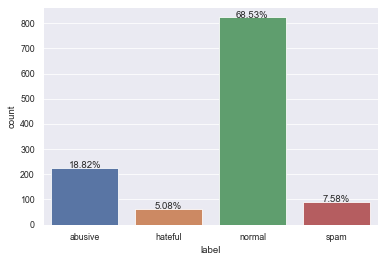

In [11]:
# set theme temporarily
sns.set_theme(context='paper', style='darkgrid', font_scale=1)

#plt.figure(figsize=(8,6))
graph = sns.countplot(x='label', data=df_tweets_us)

# annotating percentage
total = float(len(df_tweets_us['label']))
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1, f'{np.round(height/total*100, 2)}%', ha="center")

fig = graph.get_figure()
fig.savefig('figs/countplot_labels.png', dpi=400)

The labels are imbalanced with the majority of tweets being classified as "normal". Something to keep in mind!

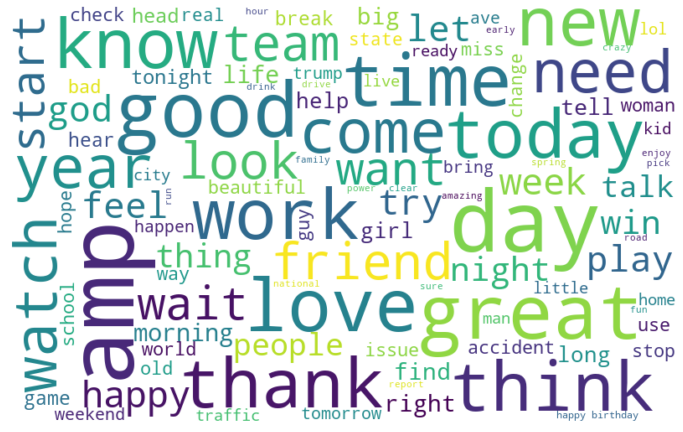

In [12]:
# "text_clean" holds lists of strings (words of tweet)
# first, all strings in single list are joined, then, all lists are joined to form single (very long) string
words_normal = ' '.join([' '.join(word_list) for word_list in df_tweets_us['text_clean'][df_tweets_us['label'] == 'normal']])

cloud_normal = WordCloud(
    width=800, height=500, 
    max_font_size=110, max_words=100,
    background_color='white'
)
cloud_normal.generate(words_normal)
plt.figure(figsize=(12,8))
plt.imshow(cloud_normal, interpolation='bilinear')
plt.axis('off')
plt.savefig('figs/cloud_normal.png', dpi=400)


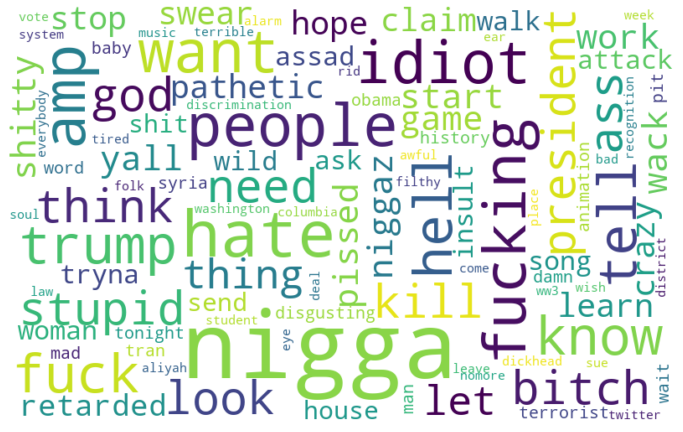

In [13]:
# plot another word cloud for hateful tweets
words_hate = ' '.join([' '.join(word_list) for word_list in df_tweets_us['text_clean'][df_tweets_us['label'] == 'hateful']])

cloud_hate = WordCloud(
    width=800, height=500, 
    max_font_size=110, max_words=100,
    background_color='white'
)
cloud_hate.generate(words_hate)
plt.figure(figsize=(12,8))
plt.imshow(cloud_hate, interpolation='bilinear') # interpolation is probably not needed!
plt.axis('off')
plt.savefig('figs/cloud_hate.png', dpi=400)

In [14]:
# bounding box provides coordinates which enclose the location of tweet (longitude, latitude)
# https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/geo#place-dictionary

# convert string of dataframe to numpy array
bb_coord_str = df_tweets_us['place_bb_coord'].values

# https://stackoverflow.com/questions/50525379/create-matrix-in-a-loop-with-numpy
temp = []
for i in range(len(bb_coord_str)):
    dummy = re.sub(r'[][,]', '', bb_coord_str[i])
    temp.append(np.fromstring(dummy, dtype=np.float, sep=' '))
bb_coord = np.array(temp)

print(bb_coord)

[[ -87.940033    41.644102   -87.523993  ...   42.0230669  -87.940033
    42.0230669]
 [-117.117116    32.582128  -116.9278103 ...   32.685406  -117.117116
    32.685406 ]
 [-117.126742    34.003904  -116.9750053 ...   34.077386  -117.126742
    34.077386 ]
 ...
 [ -81.507905    28.3882177  -81.2276403 ...   28.615139   -81.507905
    28.615139 ]
 [ -79.487651    37.886607   -74.986286  ...   39.723622   -79.487651
    39.723622 ]
 [ -73.994474    40.800683   -73.96229   ...   40.848296   -73.994474
    40.848296 ]]


2d numpy array "bb_coord" holds four pair of coordinates (lon, lat) per row indicating the edges of boundary box. 

In [22]:
# computing center of bounding box by averaging lon and lat coordinates
lon = []
lat = []
for i in range(len(bb_coord)):
    lon.append(np.average(bb_coord[i][::2]))
    lat.append(np.average(bb_coord[i][1::2]))

# adding coordinates to dataframe
df_tweets_us['lon'] = lon
df_tweets_us['lat'] = lat

# some locations aren't matching any US state (e.g., entire country was used as geotag -> averaging is nonsense!)
index = []
for i in range(len(lon)):
    if lon[i] > -30:
        index.append(i)

# removing these tweets from dataset
df_tweets_us_upd = df_tweets_us.reset_index(drop=True)
df_tweets_us_upd.drop(index=index, inplace=True)

# and saving (completely) cleaned dataset...
df_tweets_us_upd.to_csv('data/tweets_us_cleaned.csv')


C:\Users\hotte\miniconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\hotte\miniconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


C:\Users\hotte\miniconda3\envs\machinelearning\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


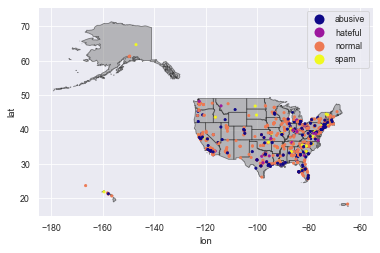

In [16]:
# plotting US map with location and labels of tweets
# following approach of: https://www.linkedin.com/pulse/geopandas-plotting-data-points-map-using-python-r%C3%A9gis-nisengwe/

# coordinate reference system
crs = {'init':'epsg:4326'}
# defining geometry
geometry = [ Point(xy) for xy in zip(df_tweets_us_upd['lon'], df_tweets_us_upd['lat']) ]
# building geopandas dataframe
df_geo = gpd.GeoDataFrame(df_tweets_us_upd, crs=crs, geometry=geometry)
# importing shapefile of US (including states)
# downloaded from: https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html
us_shapefile = gpd.read_file('data/cb_2020_us_state_5m/cb_2020_us_state_5m.shp')

# plotting
ax = us_shapefile.plot(facecolor='Grey', edgecolor='k', alpha=0.5, linewidth=0.8)
df_geo.plot(ax=ax, column='label', legend=True, cmap='plasma', categorical=True, markersize=5)
ax.set_xlabel('lon')
ax.set_ylabel('lat')
ax.set_xlim(left=-185, right=-55)
ax.set_ylim(bottom=15)
ax.grid('off')
plt.savefig('figs/US_tweet_map.png', dpi=400)

# FIXME: beautification

# FEATURE ENGINEERING & MODEL TRAINING

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.compose import ColumnTransformer

# declare RandomState instance to obtain reproducible results
rng = np.random.RandomState(42)

# (cross validation) workflow: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
# split data into training and testing sets
X_train, X_test, y_train, y_true = train_test_split(df_tweets_us_upd.drop(columns=['label']), df_tweets_us_upd['label'], test_size=0.2, random_state=rng)

# "spacy_tokenizer" took care of feature preprocessing, this function is needed as "TfidfVectorizer" applies default tokenizer otherwise!
# Applying scikit-learn TfidfVectorizer on tokenized text: https://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/
def identity_tokenizer(tweet):
    return tweet

In [48]:
# defining a pipeline combining preprocessing with random forest classifier
# applying "term frequency-inverse document frequency" (tf-idf) as text feature extractor
# following this approach: https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
# reading about common pitfalls and recommended practices: https://scikit-learn.org/stable/common_pitfalls.html

preprocessor = ColumnTransformer(
    [
        ('tfidf', TfidfVectorizer(lowercase=False, tokenizer=identity_tokenizer, preprocessor=identity_tokenizer, token_pattern=None, norm='l1'), 'text_clean'),
        ('coord', 'passthrough', ['lon', 'lat'])
    ],
    remainder='drop', n_jobs=-1,
)

pipeline = Pipeline([
    ('preproc', preprocessor), 
    ('clf', RandomForestClassifier(random_state=rng, n_jobs=-1, bootstrap=True, verbose=0))
])

# setting parameters of the estimators in pipeline (can be accessed using "<estimator>__<parameter>")
params = {
    'preproc__tfidf__max_features': (500, 1000, None), # max number of features considered (ordered by term frequency), ~4000 in total
    'preproc__tfidf__binary': (True, False), # tf term in tf-idf is binary 
    'preproc__tfidf__use_idf': (False, True), # inverse-document-frequency reweighting

    # https://scikit-learn.org/stable/modules/ensemble.html#parameters
    'clf__n_estimators': (100, 500, 1000), # number of trees in forest
    'clf__max_features': (None, 'sqrt'), # size of the random subset of features to consider when splitting a node
    'clf__max_depth': (10, 30, None), # max depth of single tree
    'clf__min_samples_split': (2, 4), # min number of tweets (=samples) required to split internal node
    'clf__min_samples_leaf': (1, 3, 5) # min number of tweets required to be at leaf node
}

if __name__ == '__main__':
    # multiprocessing requires the fork to happen in a __main__ protected block

    # find the best parameters for feature extraction and classifier
    # https://scikit-learn.org/stable/modules/cross_validation.html#a-note-on-shuffling
    cv = StratifiedShuffleSplit(n_splits=3, test_size=0.1, random_state=rng)
    grid_search = GridSearchCV(
        estimator=pipeline, param_grid=params,
        n_jobs=-1, verbose=1, error_score=0, # n_jobs is number of jobs to run in parallel (-1 means using all processors)
        cv=cv, scoring='f1_weighted'
    )
    # training model
    grid_search.fit(X_train, y_train)

    # THAT'S HOW TO ACCESS THE FUCKING MODEL!
    # http://apapiu.github.io/2016-08-04-tf_idf/
    model = grid_search.best_estimator_

    # print information about score and chosen parameters
    print('f1 score (weighted):',grid_search.best_score_) # FIXME!
    print('parameter set:')
    best_params = model.get_params()
    for param_name in sorted(params.keys()):
        print(f"\t{param_name}: {best_params[param_name]}")

    # predicting test data
    y_pred = grid_search.predict(X_test)

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits
f1 score (weighted): 0.818705476411976
parameter set:
	clf__max_depth: None
	clf__max_features: None
	clf__min_samples_leaf: 1
	clf__min_samples_split: 4
	clf__n_estimators: 100
	preproc__tfidf__binary: False
	preproc__tfidf__max_features: 500
	preproc__tfidf__use_idf: True


In [49]:
# save model with optimised parameters
import dill as pickle
pkl_filename = 'data/finalized_model.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [50]:
# alternatively, the out-of-bag samples can be used to estimate the generalization error (instead of separate validation set)
# documentation: https://scikit-learn.org/stable/modules/grid_search.html#out-of-bag-estimates
# implementation: https://stackoverflow.com/questions/34624978/is-there-easy-way-to-grid-search-without-cross-validation-in-python

# TODO:
# oob score is default score (accuracy), therefore it's unsuitable for imbalanced datasets...
# https://datascience.stackexchange.com/questions/88704/what-does-the-oob-decision-function-mean-in-random-forest-how-get-class-predict

# MODEL EVALUATION

              precision    recall  f1-score   support

     abusive       0.77      0.84      0.80        44
     hateful       0.40      0.18      0.25        11
      normal       0.87      0.92      0.89       170
        spam       0.14      0.07      0.09        15

    accuracy                           0.82       240
   macro avg       0.55      0.50      0.51       240
weighted avg       0.78      0.82      0.80       240



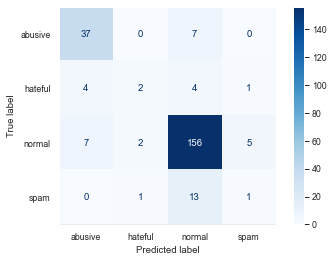

In [51]:
# classification report & confusion matrix
print(classification_report(y_true, y_pred))
fig, ax = plt.subplots(1, 1)
plot_confusion_matrix(model, X_test, y_true, cmap='Blues', ax=ax)
ax.grid(False)
fig.savefig('figs/confusion_matrix.png', dpi=400)

In [52]:
# determine feature importance

# get numerical feature importance
importances = list(model.named_steps['clf'].feature_importances_)

# create list of feature names (words and coord)
feature_list = model.named_steps['preproc'].named_transformers_['tfidf'].get_feature_names()
feature_list.extend(['lon', 'lat'])

# save feature names and importance to dataframe
df_feature_importance = pd.DataFrame({
    "feature": feature_list,
    "importance": np.round(importances, 3)
})
df_feature_importance.sort_values(by='importance', ascending=False, inplace=True)
df_feature_importance.to_csv('data/feature_importance.csv')
df_feature_importance

# further reading: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

,feature,importance
166,fucking,0.157
164,fuck,0.127
21,ass,0.038
209,idiot,0.036
39,bitch,0.030
...,...,...
247,lil,0.000
57,car,0.000
245,light,0.000
244,life,0.000


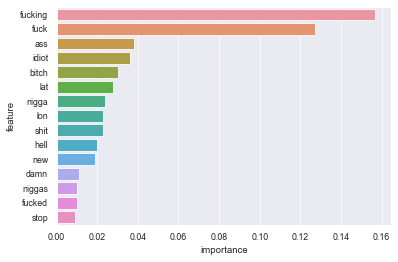

In [53]:
# visualise feature importance
sns.barplot(y='feature', x='importance', data=df_feature_importance.iloc[:15], orient='h')
plt.savefig('figs/feature_importance.png', dpi=400)

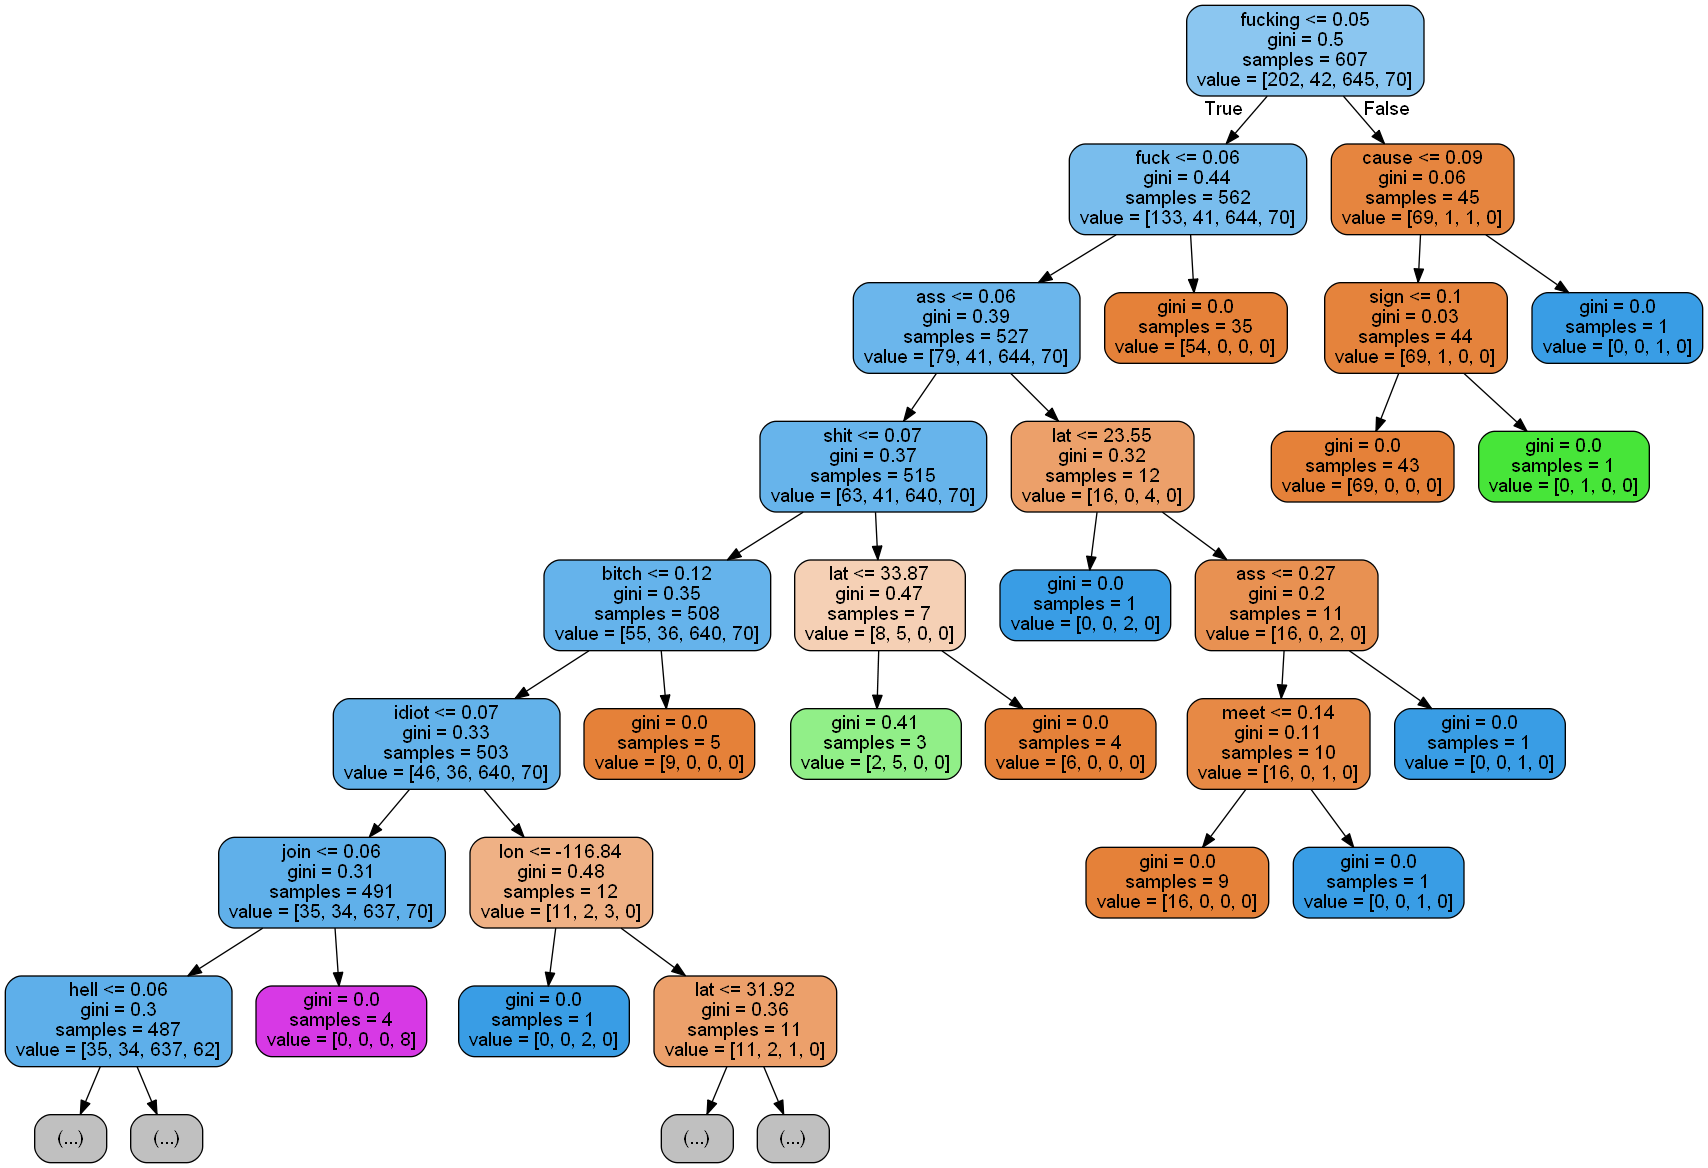

In [54]:
# visualise single tree

from sklearn.tree import export_graphviz
from IPython.display import Image, display
import pydot

# pull out single tree from forest
tree = model.named_steps['clf'].estimators_[42]

# export tree to dot file
tree_dot = export_graphviz(
    tree, feature_names=feature_list, max_depth=7,
    rounded=True, precision=2, filled=True
)

# use dot file to create a graph
(graph, ) = pydot.graph_from_dot_data(tree_dot)
# save graph as png file
graph.write_png('figs/single_tree.png')

# display tree inline
Image(filename='figs/single_tree.png')

,lat,lon,y_test,y_pred,prediction
1179,37.816453,-121.238088,abusive,abusive,True
865,26.921516,-82.357958,normal,normal,True
101,37.269176,-119.306608,normal,normal,True
440,29.838495,-95.446486,normal,normal,True
58,30.459100,-91.090800,abusive,abusive,True
...,...,...,...,...,...
383,42.313670,-71.088712,normal,normal,True
867,35.954332,-86.541606,normal,normal,True
543,39.346932,-84.550064,normal,normal,True
1194,48.198640,-122.489100,hateful,abusive,False


C:\Users\hotte\miniconda3\envs\machinelearning\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


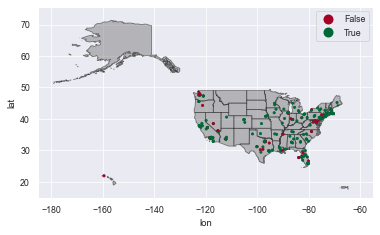

In [55]:
# plot map of wrongly predicted tweets

# create dataset holding coord and labels
df_tweets_coord = X_test.loc[:, ['lat', 'lon']]
df_tweets_coord['y_test'] = y_true
df_tweets_coord['y_pred'] = y_pred

# adding column holding prediction result
df_tweets_coord['prediction'] = np.where(df_tweets_coord['y_test'] == df_tweets_coord['y_pred'], 'True', 'False')
display(df_tweets_coord)

# plotting

# defining geometry
geometry = [ Point(xy) for xy in zip(df_tweets_coord['lon'], df_tweets_coord['lat']) ]
# building geopandas dataframe
df_geo = gpd.GeoDataFrame(df_tweets_coord, crs=crs, geometry=geometry)

ax = us_shapefile.plot(facecolor='Grey', edgecolor='k', alpha=0.5, linewidth=0.8)
df_geo.plot(ax=ax, column='prediction', legend=True, cmap='RdYlGn', categorical=True, markersize=5)
ax.set_xlabel('lon')
ax.set_ylabel('lat')
ax.set_xlim(left=-185, right=-55)
ax.set_ylim(bottom=15)
ax.grid('off')
plt.savefig('figs/US_tweet_map_prediction.png', dpi=400)